In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import random

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [146]:
display(students.sample(10))
students.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
248,GP,M,18,R,LE3,T,3.0,3.0,other,services,course,mother,1.0,2.0,1.0,no,yes,no,no,yes,-6.0,yes,yes,yes,4.0,3.0,3.0,5.0,8.0,25.0
166,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,course,father,1.0,2.0,0.0,no,no,no,no,yes,-6.0,no,yes,no,4.0,3.0,5.0,4.0,4.0,50.0
90,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,NaN,1.0,3.0,0.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,3.0,3.0,4.0,0.0,40.0
272,GP,F,18,U,LE3,T,1.0,1.0,other,other,home,mother,2.0,2.0,0.0,no,NaN,yes,no,no,-6.0,yes,no,no,4.0,4.0,3.0,3.0,2.0,55.0
56,GP,F,15,U,GT3,A,4.0,3.0,services,services,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,2.0,1.0,0.0,75.0
246,GP,M,17,U,GT3,T,2.0,3.0,other,other,course,father,2.0,1.0,0.0,no,NaN,NaN,no,yes,-3.0,yes,yes,no,5.0,2.0,2.0,2.0,4.0,65.0
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
120,GP,F,15,U,GT3,T,1.0,2.0,at_home,NaN,course,mother,1.0,2.0,0.0,no,no,no,no,no,-6.0,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
148,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,course,mother,1.0,1.0,0.0,no,yes,NaN,no,yes,-3.0,no,yes,yes,3.0,3.0,2.0,5.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [147]:
def drop_empty(df, row):
    df[row] = df[row].astype(str).apply(lambda x: None if x.strip() == '' else x)
    return df[df[row] != "nan"]


def fill_empty_random(df, row):
    values = random.choices(df[row].value_counts().index, df[row].value_counts().values, 
                                                          k= np.size(np.where(pd.isnull(df[row]))))
    
    empty = np.where(pd.isnull(df[row]))
 
    pares = {}
    for a,b in zip(empty[0], values):
        pares[a] = b
      
    df[row].fillna(value=pares, inplace=True)
    return df

def replace_fail_with_nan(df, row, allowed):
    df[row] = df[row].apply(lambda x: x if x in allowed else np.nan)
    return df


## Pre-process columns with nominative and ordinal variables with known specification first


In [172]:
nom_categories = { "sex" : ["F", "M"],
                   "address": ["U", "R"],
                   "famsize" : [ "LE3", "GT3"],
                   "Pstatus" : ["T", "A"],
                   "Medu" : [0, 1, 2, 3, 4],
                   "Fedu" : [0, 1, 2, 3, 4],
                   "Mjob": ['teacher', 'health', 'services', 'at_home', 'other'],
                   "Fjob" : ['teacher', 'health', 'services', 'at_home', 'other'],
                   "reason" : ['home', 'reputation', 'course', 'other'],
                   "guardian" : ["mother", "father", "other"],
                   "traveltime" : [1, 2, 3, 4],
                   "studytime" : [1, 2, 3, 4],
                   "failures" : [0, 1, 2, 3],
                   "schoolsup" : ["yes", "no"],
                   "famsup" : ["yes", "no"],
                   "paid" : ["yes", "no"],
                   "activities" : [ "yes", "no"],
                   "nursery" : [ "yes", "no" ],
                   "higher" : ["yes", "no"],
                   "internet" : ["yes", "no"],
                   "romantic" : ["yes", "no"],
                   "famrel" : [1, 2, 3, 4, 5],
                   "freetime" : [1, 2, 3, 4, 5],
                   "goout" : [1, 2, 3, 4, 5],
                   "health" : [1, 2, 3, 4, 5],
                  }

for row in nom_categories:
    printmd(f"### {row}")
    display(students[row].value_counts(dropna=False))
    replace_empty = False
    
    if np.nan in students[row].value_counts(dropna=False).index:
        printmd(f"#### Missing values: {students[row].value_counts(dropna=False).loc[np.nan]}")
        replace_empty = True
    else:
        printmd(f"#### No Missing values")
        
    unexpected_val = set(students[row].dropna().unique()) - set(nom_categories[row])
    
    if unexpected_val:
        printmd(f"#### Unexpected values found: {unexpected_val}")
        #At first replace with NaN to prepare for the next step
        students = replace_fail_with_nan(students, row, [0,1,2,3,4])
        replace_empty = True
    else:
        printmd(f"#### No Unexpected values discovered")
        
    if replace_empty:
        #Filling missing data by randomly selected valid values with same frequency as in remaining part of the sample:
        students = fill_empty_random(students, row)
   
    printmd("**--------------------------------------------------------**")

### sex

F    204
M    185
Name: sex, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### address

U      291
R       83
NaN     15
Name: address, dtype: int64

#### Missing values: 15

#### No Unexpected values discovered

**--------------------------------------------------------**

### famsize

GT3    255
LE3    107
NaN     27
Name: famsize, dtype: int64

#### Missing values: 27

#### No Unexpected values discovered

**--------------------------------------------------------**

### Pstatus

T      308
NaN     45
A       36
Name: Pstatus, dtype: int64

#### Missing values: 45

#### No Unexpected values discovered

**--------------------------------------------------------**

### Medu

4.0    131
2.0    100
3.0     96
1.0     56
0.0      3
NaN      3
Name: Medu, dtype: int64

#### Missing values: 3

#### No Unexpected values discovered

**--------------------------------------------------------**

### Fedu

2.0    105
3.0     94
4.0     88
1.0     75
NaN     25
0.0      2
Name: Fedu, dtype: int64

#### Missing values: 25

#### No Unexpected values discovered

**--------------------------------------------------------**

### Mjob

other       127
services     98
at_home      58
teacher      55
health       32
NaN          19
Name: Mjob, dtype: int64

#### Missing values: 19

#### No Unexpected values discovered

**--------------------------------------------------------**

### Fjob

other       194
services     99
NaN          36
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

#### Missing values: 36

#### No Unexpected values discovered

**--------------------------------------------------------**

### reason

course        135
reputation    102
home          101
other          34
NaN            17
Name: reason, dtype: int64

#### Missing values: 17

#### No Unexpected values discovered

**--------------------------------------------------------**

### guardian

mother    248
father     86
NaN        31
other      24
Name: guardian, dtype: int64

#### Missing values: 31

#### No Unexpected values discovered

**--------------------------------------------------------**

### traveltime

1.0    239
2.0     94
NaN     28
3.0     21
4.0      7
Name: traveltime, dtype: int64

#### Missing values: 28

#### No Unexpected values discovered

**--------------------------------------------------------**

### studytime

2.0    189
1.0    103
3.0     63
4.0     27
NaN      7
Name: studytime, dtype: int64

#### Missing values: 7

#### No Unexpected values discovered

**--------------------------------------------------------**

### failures

0.0    290
1.0     48
NaN     22
2.0     15
3.0     14
Name: failures, dtype: int64

#### Missing values: 22

#### No Unexpected values discovered

**--------------------------------------------------------**

### schoolsup

no     331
yes     49
NaN      9
Name: schoolsup, dtype: int64

#### Missing values: 9

#### No Unexpected values discovered

**--------------------------------------------------------**

### famsup

yes    216
no     135
NaN     38
Name: famsup, dtype: int64

#### Missing values: 38

#### No Unexpected values discovered

**--------------------------------------------------------**

### paid

no     197
yes    153
NaN     39
Name: paid, dtype: int64

#### Missing values: 39

#### No Unexpected values discovered

**--------------------------------------------------------**

### activities

yes    192
no     183
NaN     14
Name: activities, dtype: int64

#### Missing values: 14

#### No Unexpected values discovered

**--------------------------------------------------------**

### nursery

yes    297
no      77
NaN     15
Name: nursery, dtype: int64

#### Missing values: 15

#### No Unexpected values discovered

**--------------------------------------------------------**

### higher

yes    350
NaN     20
no      19
Name: higher, dtype: int64

#### Missing values: 20

#### No Unexpected values discovered

**--------------------------------------------------------**

### internet

yes    300
no      55
NaN     34
Name: internet, dtype: int64

#### Missing values: 34

#### No Unexpected values discovered

**--------------------------------------------------------**

### romantic

no     235
yes    123
NaN     31
Name: romantic, dtype: int64

#### Missing values: 31

#### No Unexpected values discovered

**--------------------------------------------------------**

### famrel

4.0    178
NaN    125
3.0     62
2.0     17
1.0      7
Name: famrel, dtype: int64

#### Missing values: 125

#### No Unexpected values discovered

**--------------------------------------------------------**

### freetime

3.0    152
4.0    110
2.0     63
5.0     37
1.0     18
NaN      9
Name: freetime, dtype: int64

#### Missing values: 9

#### No Unexpected values discovered

**--------------------------------------------------------**

### goout

3.0    126
2.0    101
4.0     81
5.0     51
1.0     23
NaN      7
Name: goout, dtype: int64

#### Missing values: 7

#### No Unexpected values discovered

**--------------------------------------------------------**

### health

5.0    137
3.0     88
4.0     60
1.0     47
2.0     42
NaN     15
Name: health, dtype: int64

#### Missing values: 15

#### No Unexpected values discovered

**--------------------------------------------------------**

## Check columns with nominative and ordinal variables with unknown specification or missing description

### school

In [149]:
students.school.value_counts(dropna=False)

GP    349
MS     46
Name: school, dtype: int64

**No unexpected values discovered, no missing values**

### studytime, granular

In [150]:
students['studytime, granular'].value_counts(dropna=False)

-6.0     194
-3.0     103
-9.0      64
-12.0     27
 NaN       7
Name: studytime, granular, dtype: int64

<AxesSubplot:title={'center':'Father education period'}>

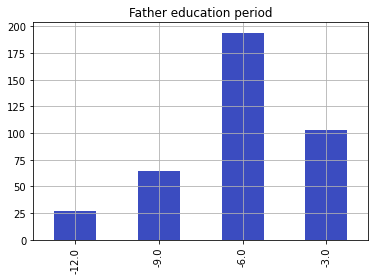

In [151]:
students['studytime, granular'].value_counts().sort_index().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Father education period')

**Some values are missing, looks like interval variable, missing values potentially fillable like other nominative variables for this data set with fill_empty_random() function, but will not do this for now**

## Check columns with numerical variables

### age

In [152]:
students.loc[:,["age"]].describe()

,age
count,395.000000
mean,16.696203
std,1.276043
min,15.000000
25%,16.000000
50%,17.000000
75%,18.000000
max,22.000000


<AxesSubplot:>

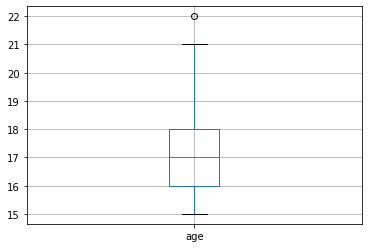

In [153]:
students.boxplot(column=['age'])

We can see that one outlayer is present with value 22

<AxesSubplot:title={'center':'Students by age'}>

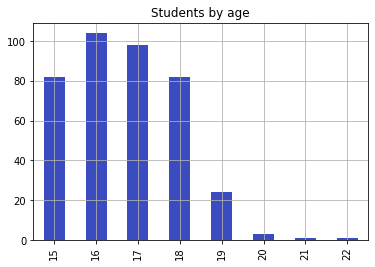

In [154]:
students['age'].value_counts().sort_index().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Students by age')

Lets replace outlaying value 22, with maximum closes not outlaying value which is 21.

In [155]:
students["age"].replace(22,21, inplace=True)

In [156]:
students["age"].value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
21      2
Name: age, dtype: int64

### Absense

In [157]:
students.loc[:,["absences"]].describe()

,absences
count,383.000000
mean,7.279373
std,23.465197
min,0.000000
25%,0.000000
50%,4.000000
75%,8.000000
max,385.000000


<AxesSubplot:title={'center':'Students by absences'}>

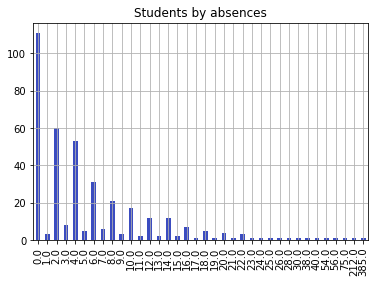

In [158]:
students.absences.value_counts().sort_index().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Students by absences')

We can see that some values are missing and distributions of absenses per students has anomalies. There are more odd absenses registered per student than even. And this is strange. Let's fill na with median value of this sample and look at boxplot.

In [159]:
students.absences.fillna(students.absences.median())

0        6.0
1        4.0
2       10.0
3        2.0
4        4.0
       ...  
390    212.0
391      3.0
392      3.0
393      0.0
394      5.0
Name: absences, Length: 395, dtype: float64

<AxesSubplot:>

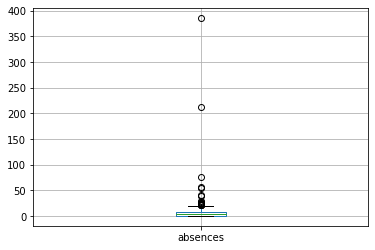

In [160]:
students.boxplot(column=['absences'])

Boxplot shows that there are many outlayers in this sample. Let's look closer at them:

In [161]:
Q1 = students.absences.quantile(q=0.25, interpolation='midpoint')
Q2 = students.absences.quantile(q=0.75, interpolation='midpoint')
max_lim =  Q2 + (Q2-Q1) * 1.5 
display(max_lim)

20.0

In [162]:
students[students["absences"] > 20]["absences"].count()

17

Let's replace outlayers with max_lim

In [163]:
students["absences"] = students["absences"].apply(lambda x: x if x <= 20 else 20)

### score

In [164]:
students.loc[:,["score"]].describe()

,score
count,389.000000
mean,52.262211
std,22.919022
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,100.000000


#### Drop 6 rows where taget value is not specified:


In [165]:
students = drop_empty(students, "score")


In [166]:
students.score = students.score.astype(float)

<AxesSubplot:title={'center':'Students by score'}>

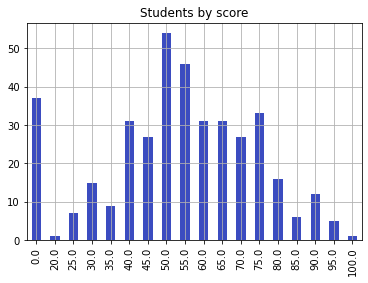

In [167]:
students.score.value_counts().sort_index().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Students by score')


<AxesSubplot:>

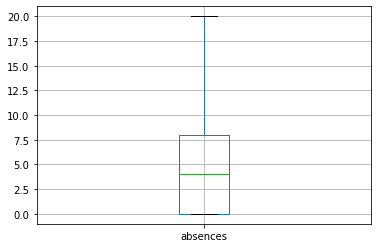

In [168]:
students.boxplot(column=['absences'])

No outliers! Very good!

## Correlation analisys for quantitative variables

In [178]:
correlation = students[["age", "absences", "score"]].corr()


<AxesSubplot:>

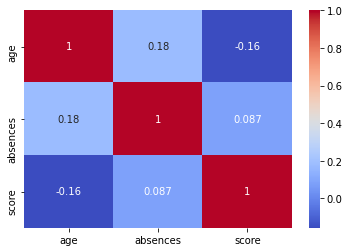

In [179]:
sns.heatmap(correlation, annot = True, cmap = "coolwarm")

We can see that score and age are not correlated, thus we can leave these two samples for further use.

## Analisys for nominal and ordinal variables

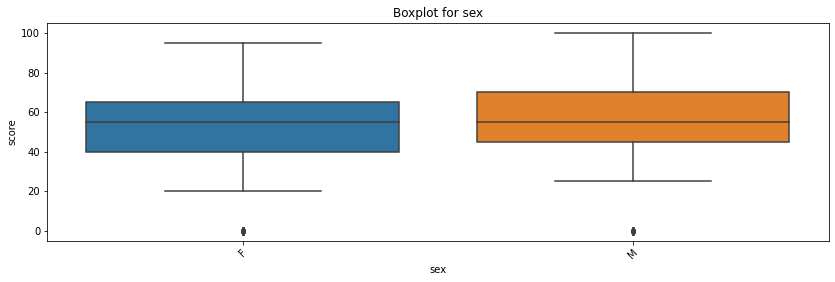

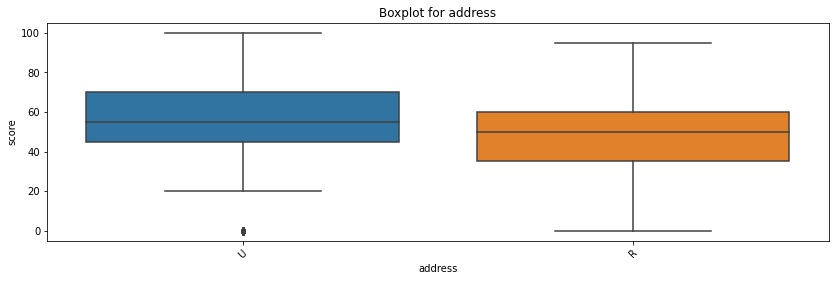

'Найдены статистически значимые различия для колонки'

'address'

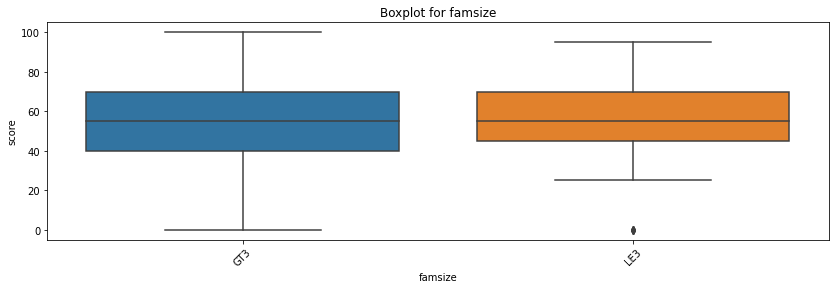

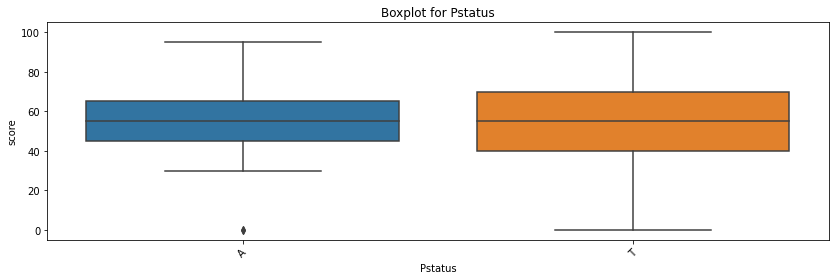

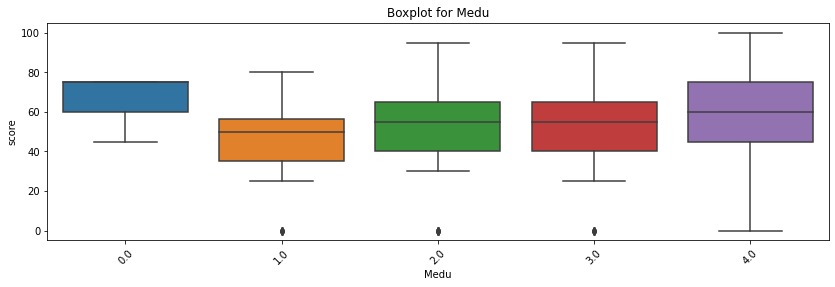

'Найдены статистически значимые различия для колонки'

'Medu'

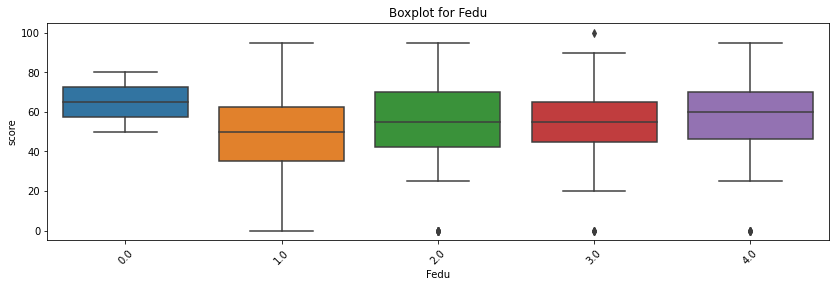

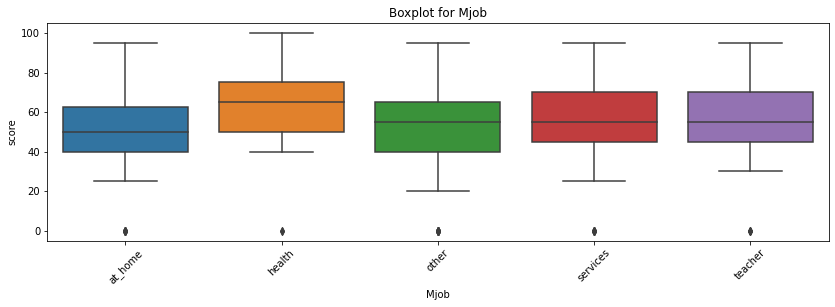

'Найдены статистически значимые различия для колонки'

'Mjob'

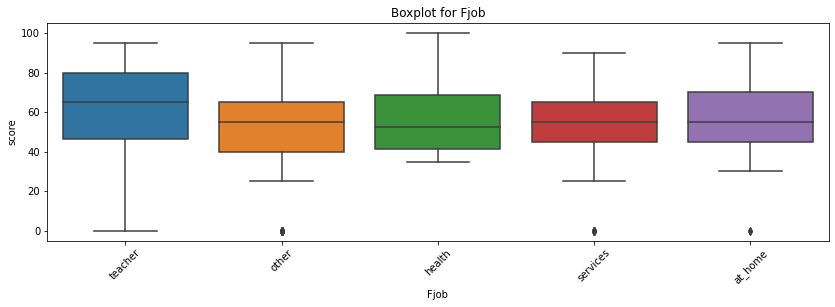

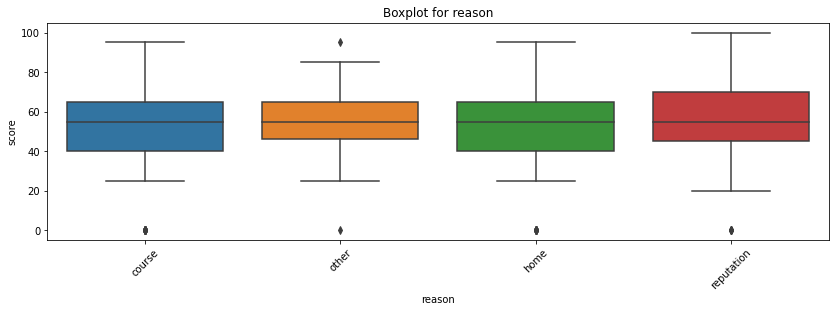

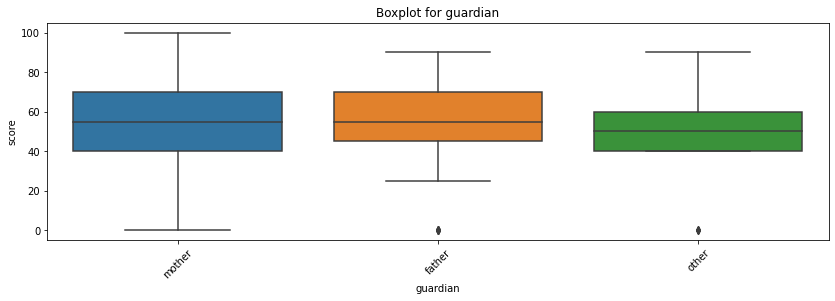

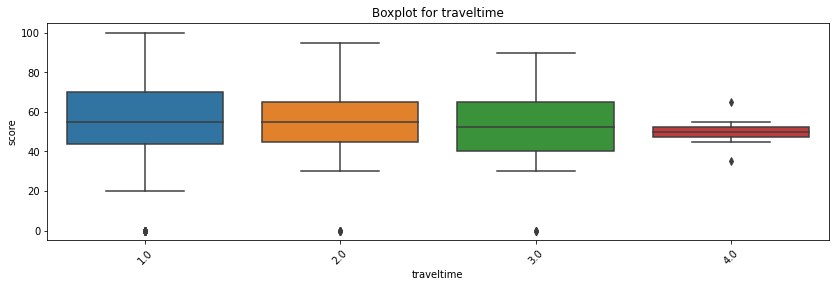

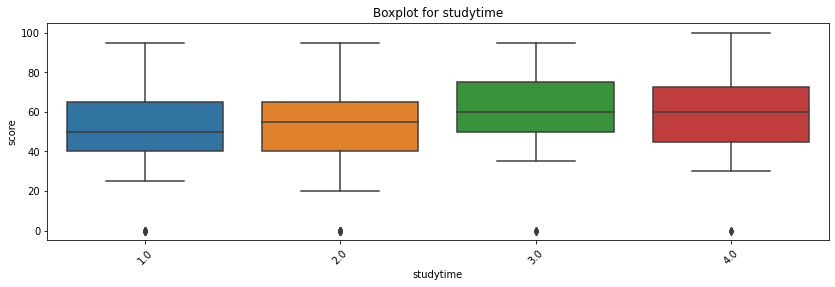

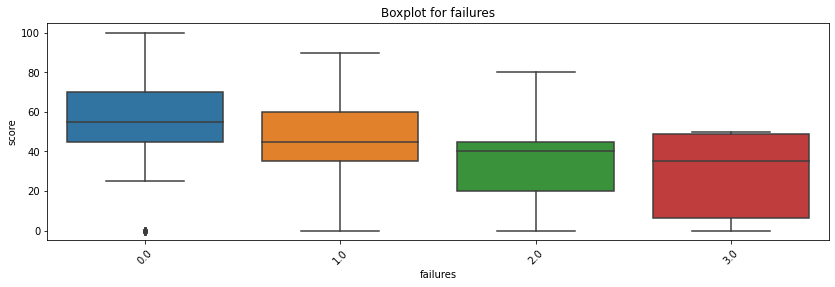

'Найдены статистически значимые различия для колонки'

'failures'

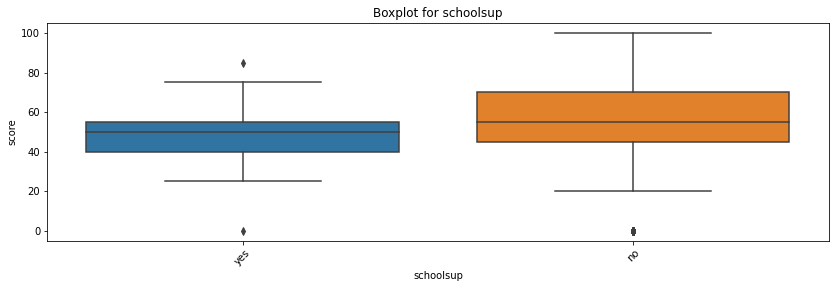

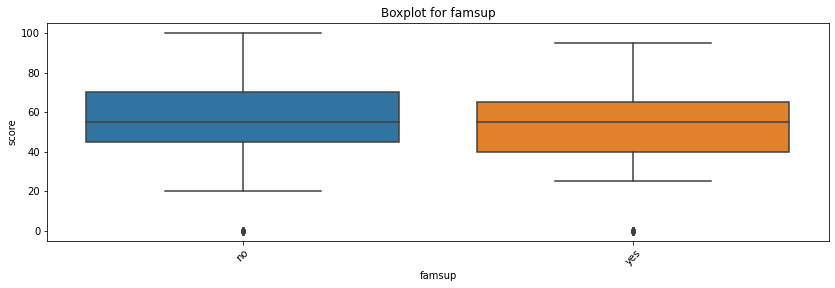

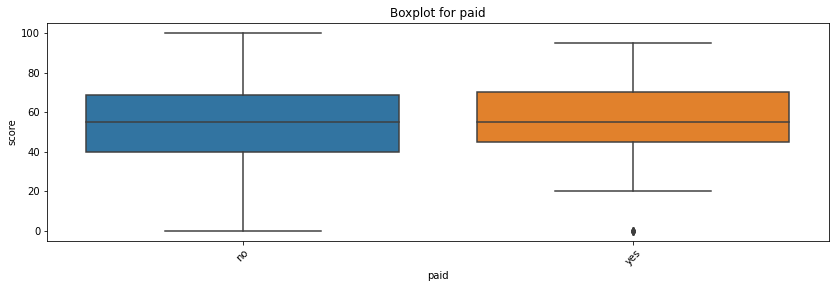

'Найдены статистически значимые различия для колонки'

'paid'

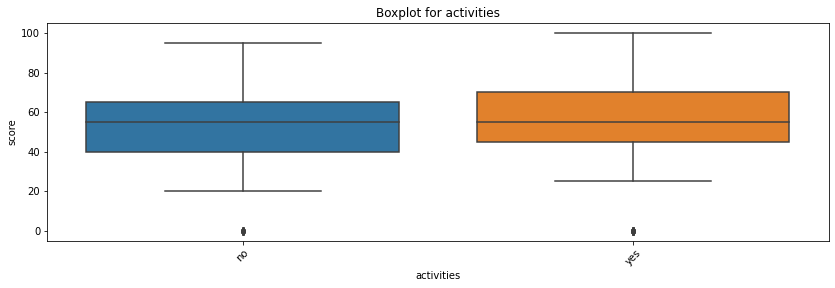

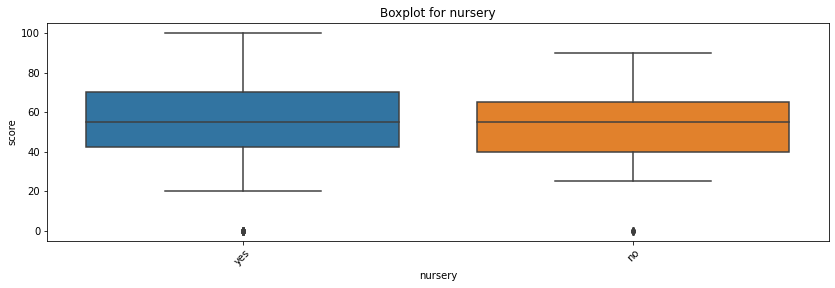

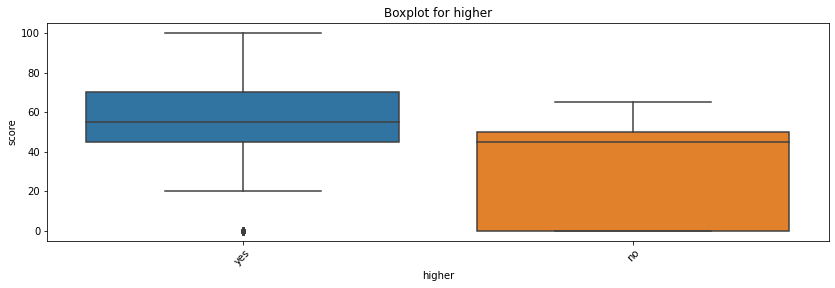

'Найдены статистически значимые различия для колонки'

'higher'

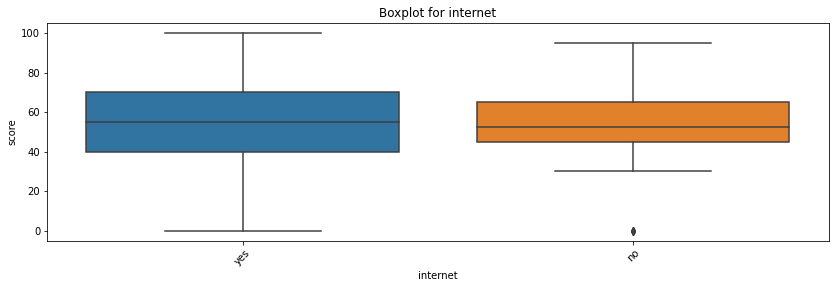

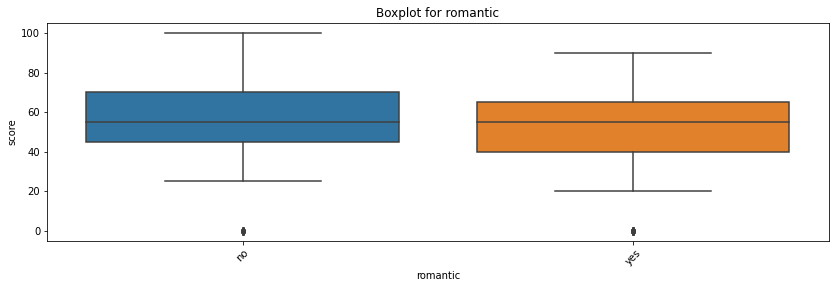

'Найдены статистически значимые различия для колонки'

'romantic'

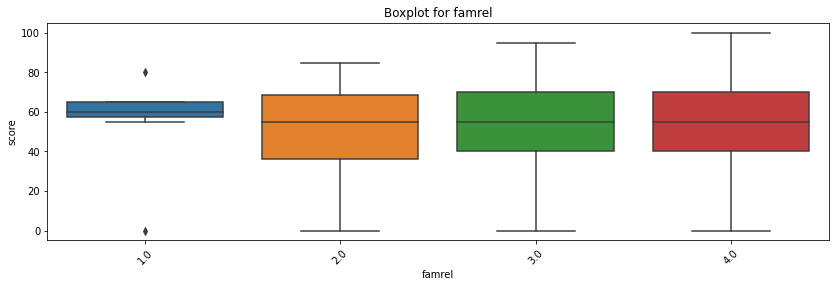

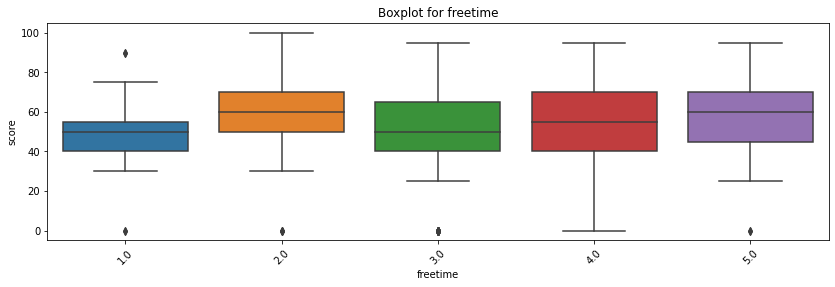

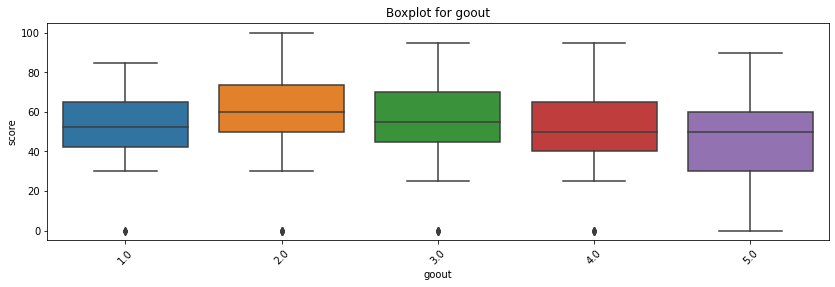

'Найдены статистически значимые различия для колонки'

'goout'

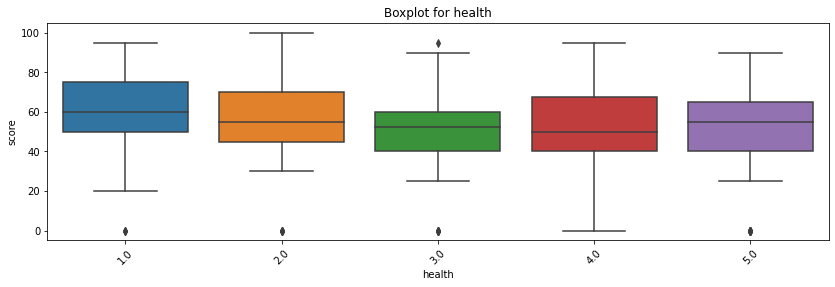

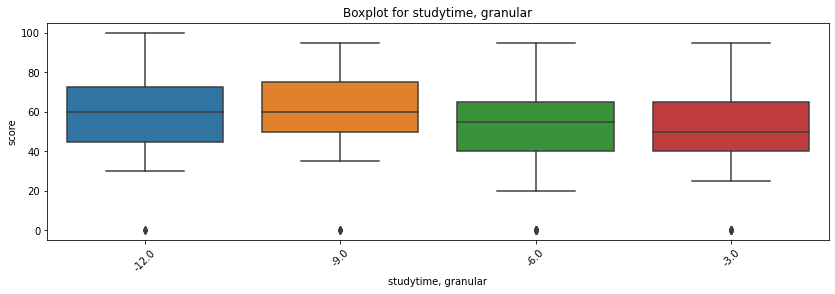

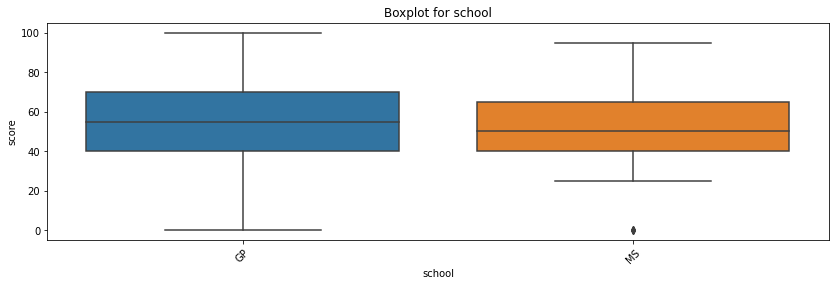

In [194]:
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        a = ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                     students.loc[students.loc[:, column] == comb[1], 'score']).pvalue
        if a <= 0.05/len(combinations_all): # Учли поправку Бонферони
            display('Найдены статистически значимые различия для колонки', column)
            break


def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=students,
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    get_stat_dif(column)
    
    
for row in list(nom_categories) + ['studytime, granular', 'school']:
    get_boxplot(row)